In [19]:
import numpy as np
import pandas as pd
import pandasql as ps
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)


# reading the data 

In [20]:
row_df = pd.read_excel('chen_shalev_labeld_row_data.xlsx')

In [21]:
df = row_df[:]  # object copy

### good/bad flaging

In [22]:
good_placing = np.logical_or(df['label'] == 1 , df['label'] == 2)
bad_placing  = ~good_placing


In [37]:
df.loc[bad_placing,'is_good_placing'] = 0
df.loc[good_placing,'is_good_placing'] = 1


# arab_not_arab_flaging

In [24]:
df = df[['לשכה מקודדת','שפות','דת','label','is_good_placing']]

In [25]:
contains = df['שפות'].str.contains('ערבית') & (df['דת'].str.contains('יהודי')==False)
not_contains = [not x for x in contains]
df.loc[contains, 'is_arab'] = 1
df.loc[not_contains, 'is_arab'] = 0

In [38]:
pd.set_option("display.max_rows", 200)
df.head(10)

,לשכה מקודדת,שפות,דת,label,is_good_placing,is_arab
0,ד16,"עברית -בסיסית, ערבית -שפת אם",מוסלמי,4,0.0,1.0
1,ד16,"עברית -בסיסית, ערבית -שפת אם",מוסלמי,3,0.0,1.0
2,ד16,"עברית -גבוהה, ערבית -שפת אם",מוסלמי,2,1.0,1.0
3,ד16,"עברית -בסיסית, ערבית -שפת אם",מוסלמי,4,0.0,1.0
4,ד16,ערבית -שפת אם,מוסלמי,2,1.0,1.0
5,ד16,"עברית -בסיסית, ערבית -שפת אם",מוסלמי,4,0.0,1.0
6,ד16,"עברית -בסיסית, ערבית -שפת אם",מוסלמי,4,0.0,1.0
7,ד16,"עברית -גבוהה, ערבית -שפת אם",מוסלמי סוני,4,0.0,1.0
8,ד16,"עברית -בסיסית, ערבית -שפת אם",מוסלמי,2,1.0,1.0
9,ד16,"עברית -בסיסית, ערבית -שפת אם",מוסלמי,4,0.0,1.0


In [27]:
df_ready = df[['לשכה מקודדת','is_arab','is_good_placing']]
df_ready.head()

,לשכה מקודדת,is_arab,is_good_placing
0,ד16,1.0,0.0
1,ד16,1.0,0.0
2,ד16,1.0,1.0
3,ד16,1.0,0.0
4,ד16,1.0,1.0


## data manipulation - extracting count and proportions of each office and nation

In [28]:
agg_data = ps.sqldf(f"""select a.office,
                               a.is_arab,
                               a.count_office_and_nation,
                               b.count_office,
                               a.count_office_and_nation * 1.0/ b.count_office proption_within_office,
                               a.avg as proportion_of_good_placing
                               
                        from
                        (SELECT  "לשכה מקודדת" as office,
                                is_arab,
                                count(*) count_office_and_nation,       
                                AVG(is_good_placing) avg
                       FROM df_ready 
                       group by 1,2) a
                       
                       left join (select "לשכה מקודדת" as office,
                                        count(*) count_office
                                from df_ready
                                group by 1) b
                        on a.office = b.office
                        
                        inner join (SELECT office
                                    from
                                        (select "לשכה מקודדת" as office,
                                                 is_arab,
                                                 count(*) count_office_and_nation 
                                         FROM df_ready 
                                         group by 1,2
                                         having count_office_and_nation > 14)
                                    group by 1 
                                    having count(office) = 2 ) c
                            on a.office = c.office
                            
                       ;
                       """, globals())

In [29]:
agg_data.head()

,office,is_arab,count_office_and_nation,count_office,proption_within_office,proportion_of_good_placing
0,א4,0.0,2220,2553,0.869565,0.185135
1,א4,1.0,333,2553,0.130435,0.165165
2,א6,0.0,787,1006,0.782306,0.111817
3,א6,1.0,219,1006,0.217694,0.114155
4,ב10,0.0,101,1872,0.053953,0.099010


### lets check if our data id taken from normal distribution

In [30]:
flat_agg_data = ps.sqldf(f"""select *,
                                    not_arab_proportion  - arab_proportion as diff
                            from(
                                SELECT  office,
                                         max(case when is_arab = 1 then count_office_and_nation end ) arab_count_within_office,
                                         max(case when is_arab = 0 then count_office_and_nation end ) not_arab_count_within_office,

                                         max(case when is_arab = 1 then proportion_of_good_placing end ) arab_proportion,
                                         max(case when is_arab = 0 then proportion_of_good_placing end ) not_arab_proportion 
                               FROM agg_data 
                               group by 1 )
                        """, globals())

In [31]:
flat_agg_data

,office,arab_count_within_office,not_arab_count_within_office,arab_proportion,not_arab_proportion,diff
0,א4,333,2220,0.165165,0.185135,0.019970
1,א6,219,787,0.114155,0.111817,-0.002338
2,ב10,1771,101,0.109543,0.099010,-0.010533
3,ב3,2916,1725,0.141975,0.149565,0.007590
4,ב5,1068,644,0.082397,0.083851,0.001454
5,ב8,43,39,0.023256,0.102564,0.079308
6,ג1,250,2714,0.196000,0.231393,0.035393
7,ג11,444,482,0.141892,0.124481,-0.017411
8,ג3,22,44,0.090909,0.022727,-0.068182
9,ג5,1983,106,0.177005,0.132075,-0.044929


## checking for normality 

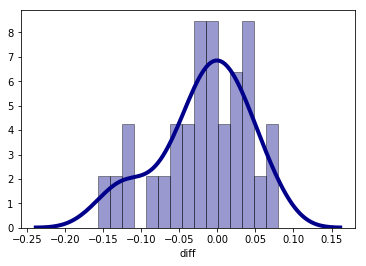

In [32]:
a= flat_agg_data['diff'] 
sns.distplot(a, hist=True, kde=True, 
             bins=15, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}
            )


# Our data  cdf and theoretical values cdf from normal distribution

In [33]:
def ks_plot_norm(data):
    length = len(data)
    plt.figure(figsize=(10, 5))
    plt.plot(np.sort(data), np.linspace(0, 1, len(data), endpoint=False))
    plt.plot(np.sort(stats.norm.rvs(loc=np.mean(data), scale=np.std(data), size=len(data))), np.linspace(0, 1, len(data), endpoint=False))
    plt.legend('top right')
    plt.legend(['Data', 'Theoretical Values'])
    plt.title('Comparing CDFs for KS-Test')

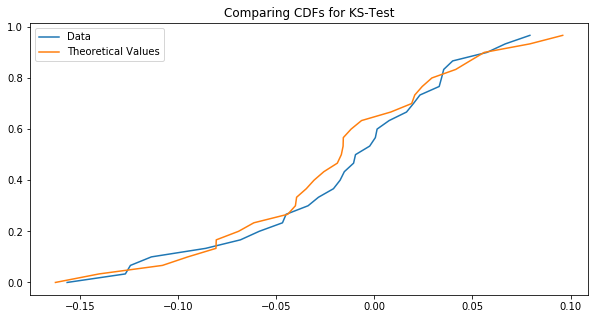

In [34]:
ks_plot_norm(a)

###### looks like our data cdf is very close to cdf of normal distribution, now we just need to test it, we choose to use the Kolmogorov Smirnov test for normality

# Kolmogorov Smirnov test for normality

#### Normalization of data

In [35]:
a = (a - np.mean(a))/np.std(a)

In [39]:
sp.stats.kstest(a, 'norm')

KstestResult(statistic=0.1160630351595065, pvalue=0.8137852163264059)

#### The P_value we get is much more bigger than 0.05 , that meaning we do not reject the null hypothesis which says that are data belongs to the normal distribution


# t-test
### since we have 30 samples and we saw that the data is normaly distributed we can use t-test

We will use the following formula to examine the difference between dependent pairs.
It is assumed that there are more similar characteristics to populations from the same offices

\begin{align}
H_0: \mu = 0 \\
H_1: \mu !=  0 \\
\end{align}

 when our statistic is 
 

$$ t =  \frac{\bar{D}}{\sqrt{\frac{s^2}{n}}}$$ 
when
$$ \bar{D} =  \frac{1}{n} \sum{X-Y}$$ 


### calculation of accepted value estimator ( the average)
 
$$ \bar{D} =  \frac{1}{n} \sum{X-Y}$$ 

In [40]:
D_bar = flat_agg_data['diff'].mean()
D_bar

-0.01826748065950308

### calculation of variance estimator
 
$$ s^2 $$ 

In [41]:
s_2 = flat_agg_data['diff'].var()
s_2

0.00352159108043281

### calculation of our statistic

In [42]:
n = flat_agg_data.shape[0]
stat = D_bar/((s_2/n)**0.5)
stat

-1.6860475597295403

## final check - do the statistic is less then the critical value?

In [43]:
scipy.stats.t.ppf(0.95,29)

1.6991270265334972

In [44]:
stat <= scipy.stats.t.ppf(0.95,29)

True

## same results but by taking a look over the p_value

In [45]:
print(f"""p_value equal to: {scipy.stats.t.pdf(stat,29)} 
do our p_value is less then 0.05 ? answer:{ scipy.stats.t.pdf(stat,29) < 0.05}""")

p_value equal to: 0.09726958112890556 
do our p_value is less then 0.05 ? answer:False


### so we can say confidently that there is no diff between arabs and non arabs 